In [1]:
# Importing core scientific libraries
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  

# Importing image processing libraries
from PIL import Image, ExifTags  

# Importing libraries for working with HDF5 files
import h5py  
from IPython.display import display  

# Importing PyTorch libraries for deep learning
import torch  
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader  

# Importing Hugging Face datasets library
from datasets import load_dataset  
import datasets  
from datasets import Dataset  

# Importing Hugging Face transformers library for Vision Transformer
from transformers import ViTImageProcessor  
from transformers import TrainingArguments, Trainer  
from transformers import ViTForImageClassification

# Importing scikit-learn libraries
from sklearn.metrics import mean_squared_error


/home/ziad/miniconda3/envs/pepnet/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


-6.6


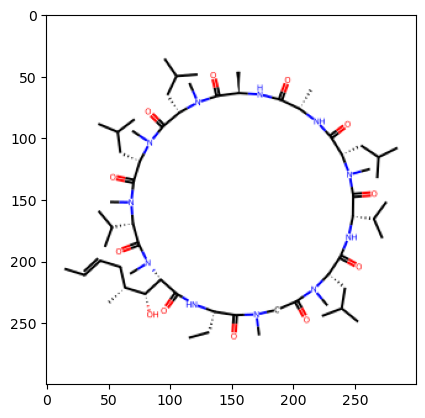

<PIL.Image.Image image mode=RGB size=300x300 at 0x7FC91A722AB0> (14184,)


In [2]:
# Load the data from the h5py file
h5file = '../../../docs/data/Augmented_PepNet_data.h5'

with h5py.File(h5file, 'r') as F:
    data = np.array(F['images'])
    data = np.clip(data, 0, 255).astype(np.uint8)
    data = [Image.fromarray(img) for img in data]

    labels = np.array(F['permeability'])

#Verify the data
print(labels[0])
plt.imshow(data[0])
plt.show()
print(data[0], labels.shape)

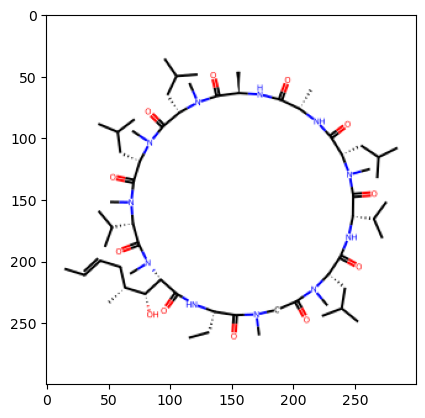

In [3]:
#Check if we can recontruct the image
img_array = np.array(data[0])
plt.imshow(img_array)

In [4]:
# Split sizes
train_size = 11000
val_size = 2000
test_size = 1000

# Randomly shuffle the data
np.random.shuffle(data)

# Split the data
train_data = data[:train_size]
val_data = data[train_size:train_size+val_size]
test_data = data[train_size+val_size:train_size+val_size+test_size]

train_labels = labels[:train_size]
val_labels = labels[train_size:train_size+val_size]
test_labels = labels[train_size+val_size:train_size+val_size+test_size]

train_dict = {"img": train_data, "label": train_labels}
val_dict = {"img": val_data, "label": val_labels}
test_dict = {"img": test_data, "label": test_labels}

train_dataset = datasets.Dataset.from_dict(train_dict)
val_dataset = datasets.Dataset.from_dict(val_dict)
test_dataset = datasets.Dataset.from_dict(test_dict)



<class 'datasets.arrow_dataset.Dataset'> <class 'datasets.arrow_dataset.Dataset'> <class 'datasets.arrow_dataset.Dataset'>


####################################### Preprocessing the Data #######################################

In [7]:
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

In [8]:
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

In [9]:
train_dataset.set_transform(train_transforms)
val_dataset.set_transform(val_transforms)
test_dataset.set_transform(val_transforms)

In [11]:

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=4)

In [12]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


#################################### Define the Model    ##############################################

In [107]:
class ViTForRegression(ViTForImageClassification):
    def __init__(self, config):
        super().__init__(config)
        # Add additional layers before the final output layer
        self.additional_layers = nn.Sequential(
            nn.Linear(config.hidden_size, config.hidden_size),  # Add a linear layer
            nn.ReLU(),  # Add activation function
            nn.Linear(config.hidden_size, config.hidden_size)  # Add another linear layer
        )
        # Modify the output layer for regression
        self.classifier = nn.Linear(config.hidden_size, 1)  # Output a single value


# Create model instance
model = ViTForRegression.from_pretrained('google/vit-base-patch16-224-in21k',num_labels=1) #num_labels=1 to solve the target dimension mismatch with the input


Some weights of ViTForRegression were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['additional_layers.0.bias', 'additional_layers.0.weight', 'additional_layers.2.bias', 'additional_layers.2.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:

metric_name = "mean_squared_error"

args = TrainingArguments(
    f"../../../Results/Models/ViT_Tuned",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=5e-4, 
    per_device_train_batch_size=8, 
    per_device_eval_batch_size=4, 
    num_train_epochs=100, 
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

/home/ziad/miniconda3/envs/pepnet/lib/python3.12/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [15]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    return dict(mean_squared_error=mean_squared_error(predictions, labels))    

In [16]:

trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

######################################## Train the Model ######################################

# Start tensorboard.
!load_ext tensorboard
!tensorboard --logdir logs/

In [17]:
trainer.train()

Epoch,Training Loss,Validation Loss,Mean Squared Error
1,0.615800,0.472980,0.472980
2,0.628400,0.520048,0.520048
3,0.625700,0.601928,0.601928
4,0.595500,0.491026,0.491026
5,0.595000,0.479528,0.479528
6,0.578300,0.466108,0.466108
7,0.617400,0.516610,0.516610
8,0.622400,0.446881,0.446881
9,0.586100,0.453386,0.453386
10,0.625700,0.497103,0.497103


TrainOutput(global_step=137500, training_loss=0.6017236361416903, metrics={'train_runtime': 14781.6228, 'train_samples_per_second': 74.417, 'train_steps_per_second': 9.302, 'total_flos': 8.64139129362432e+19, 'train_loss': 0.6017236361416903, 'epoch': 100.0})

###################################### Evaluate the Model ################################################

In [105]:
# Predict the targets on the test dataset using the best model
outputs = trainer.predict(test_dataset)

##################################### Save the metrics and predictions for analysis ###################################

In [33]:
# Save the metrics
with open("../../../Results/ViT_Tuned_Metrics.txt", "w") as f:
    f.write(str(outputs.metrics))

# Save the predictions
df= pd.DataFrame({"True Values": outputs.label_ids, "Predicted Values": outputs.predictions.flatten()})
df.to_csv("../../../Results/ViT_Tuned_Predictions.csv", index=False)

######################################### Plot the predictions and true values ##############################################

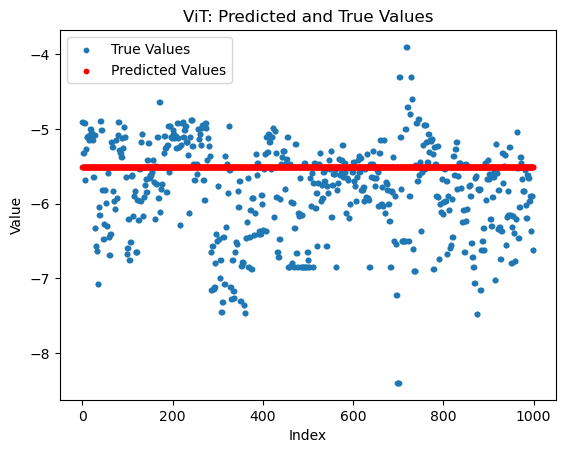

In [101]:
# Load the predictions from the CSV file
df = pd.read_csv("../../../Results/ViT_Tuned_Predictions.csv")

# Extract the predicted and true values
predicted_values = df["Predicted Values"]
true_values = df["True Values"]
index = [i for i in range(len(true_values))]

# Plot the predicted and true values
plt.scatter(index,true_values, label="True Values", s=10)
plt.scatter(index,predicted_values, label="Predicted Values", color="red", s=10)
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("ViT: Predicted and True Values")

plt.legend()
plt.show()

####################################### Plot training loss #############################################

376


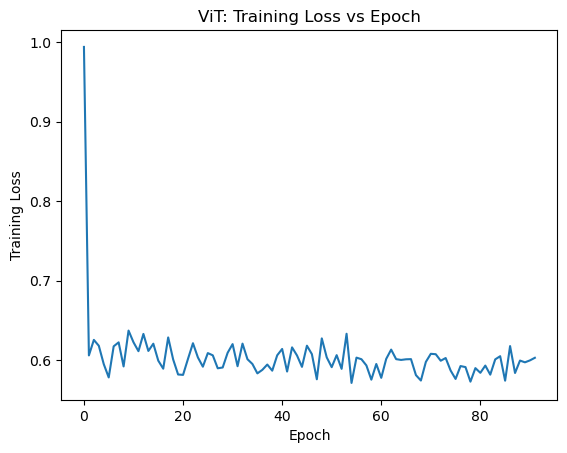

In [104]:
# Load the training loss
loss = []
print(len(trainer.state.log_history))
for i in range(0, len(trainer.state.log_history)):
    try:
        training_loss_per_epoch = trainer.state.log_history[i]['loss']
        loss.append(training_loss_per_epoch)
    except KeyError:
        # 'loss' key doesn't exist, skip this iteration
        continue

# Convert the loss list to a numpy array
loss_array = np.array(loss)

# Calculate the step size to select uniformly distant points
step_size = len(loss_array) // 90

# Select uniformly distant points from the loss array
selected_points = loss_array[::step_size]

# Plot the training loss
plt.plot(selected_points)
#plt.ylim(0, 1)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("ViT: Training Loss vs Epoch")
plt.show()

############################# Compute the accuracy within the defined threshold #####################################

In [106]:
# Load the predictions from the CSV file
df = pd.read_csv("../../../Results/ViT_Tuned_Predictions.csv")

# Extract the predicted and true values
predicted_values = df["Predicted Values"]
true_values = df["True Values"]

threshold = 0.15
correct = 0
for i in range(0, len(true_values)):
    if np.abs(predicted_values[i] - true_values[i]) < threshold * np.abs(true_values[i]):
        correct += 1

accuracy = correct / len(true_values)
print(accuracy)

0.8
